<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Example Code for using the DIDV class

Import the needed packages to run the test script.

In [1]:
from qetpy import DIDV
import matplotlib.pyplot as plt
import numpy as np
import h5py

%matplotlib inline

Set all of the necessary parameters and load the traces from an HDF5 file in the repository.

In [2]:
# Setting various parameters that are specific to the dataset
rshunt = 5e-3
rbias_sg = 20000
rfb = 5000
loopgain = 2.4
adcpervolt = 65536 / 2
fs = 625e3
sgfreq = 100
sgamp = 0.009381 / rbias_sg
drivergain = 4
rp = 0.0060367199999999998
rload = rshunt + rp
drload = 0.0001
r0 = 0.075570107054005367
dr0 = 8.96383052e-04

convtoamps = rfb * loopgain * drivergain * adcpervolt

# load the dataset
with h5py.File('example_traces.h5','r') as f:
    rawtraces = np.array(f["rawTraces"])

# set the priors information, for use the priors fitting
priors = np.zeros(7)
invpriorscov = np.zeros((7,7))
priors[0] = rload
priors[1] = r0
invpriorscov[0, 0] = 1 / drload**2
invpriorscov[1, 1] = 1 / dr0**2
dt0 = -18.8e-6

Run the processing package on the data.

2-Pole Priors Fit Failed: The maximum number of function evaluations is exceeded.


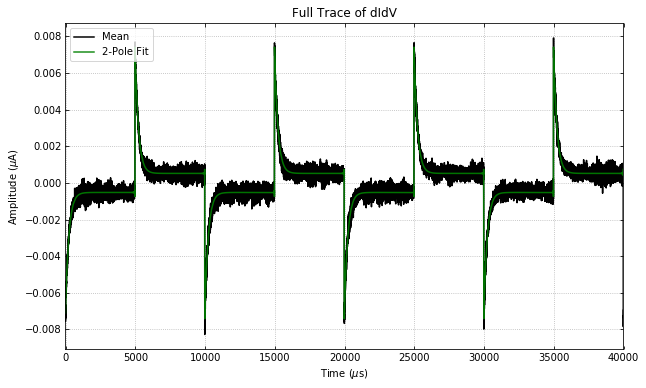

In [3]:
didvfit = DIDV(
    rawtraces,
    fs,
    sgfreq,
    sgamp,
    rshunt,
    tracegain=convtoamps,
    priors=priors,
    invpriorscov=invpriorscov,
)

# note that there are many more attributes for DIDV

didvfit.processtraces()
didvfit.doallfits()
# didvfit.dofit(2) # just do one fit
didvfit.plot_full_trace(poles=2, plotpriors=False)

Let's look at the fit parameters for the 2-pole fit.

In [4]:
didvfit.fitparams2

array([ 2.91338904e-01,  1.96261960e+00,  1.87363027e-03,  9.97908425e-07,
       -1.88710545e-05])

In [5]:
didvfit.irwinparams2

array([ 1.00000000e-02,  3.00000000e-01, -6.22036528e-02,  7.71482552e-01,
        2.90729547e-07,  4.28157207e-04, -1.88710545e-05])

In [6]:
didvfit.get_irwinparams_dict(2)

{'rload': 0.01,
 'r0': 0.3,
 'beta': -0.062203652825646105,
 'l': 0.771482552122021,
 'L': 2.907295469988362e-07,
 'tau0': 0.00042815720654307293,
 'dt': -1.887105448791047e-05,
 'tau_eff': 0.0002413064572931682}

Let's see what dIdV(0) is.

In [7]:
didvfit.didvfit2_freqdomain[0].real

0.44366389157720754

What are the fall times?

In [8]:
didvfit.falltimes2

array([1.00151672e-06, 2.41306457e-04])

Let's play with the plotting functions available.

Let's first plot all of this fits on the full trace.

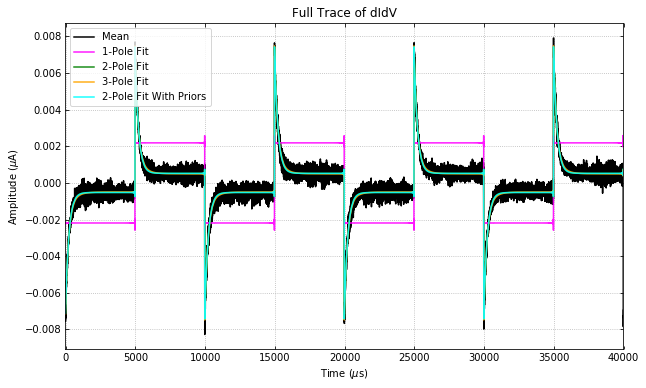

In [9]:
didvfit.plot_full_trace(poles="all", plotpriors=True)

Now let's plot a single trace and save the file to the current directory. If a different directory is wanted, then use the `savepath` variable.

In [10]:
didvfit.plot_single_period_of_trace(poles=[2, 3], lgcsave=True, savename="test", plotpriors=False)

Let's plot a zoomed in trace of just the 2 pole fit. Note that by default, all fits are plotted.

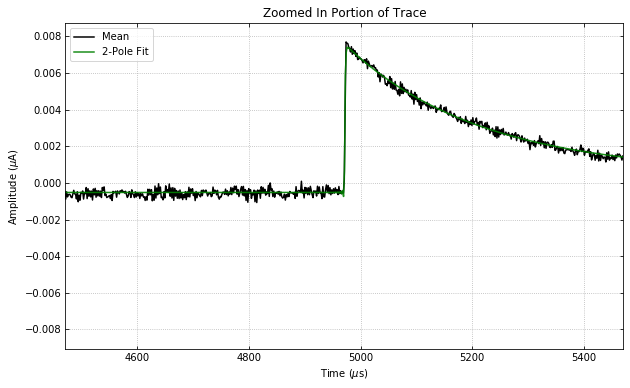

In [11]:
didvfit.plot_zoomed_in_trace(poles=2, plotpriors=False)

Let's flip the trace and shift it by half a period of the signal generator in order to see if there are any nonlinearities. Spoiler alert: there aren't!

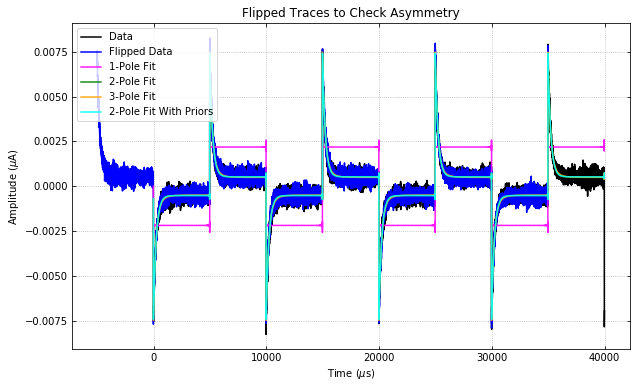

In [12]:
didvfit.plot_didv_flipped()

Now let's look at the real and imaginary parts of the dIdV.

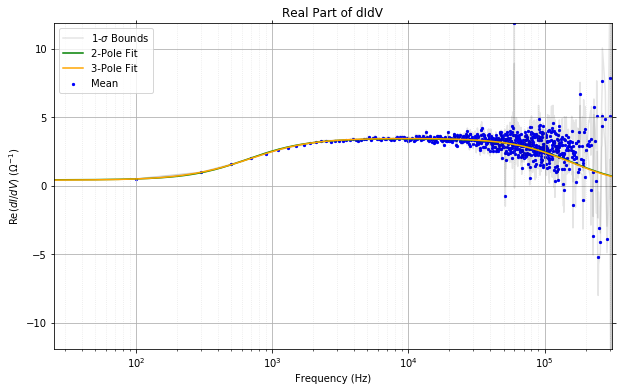

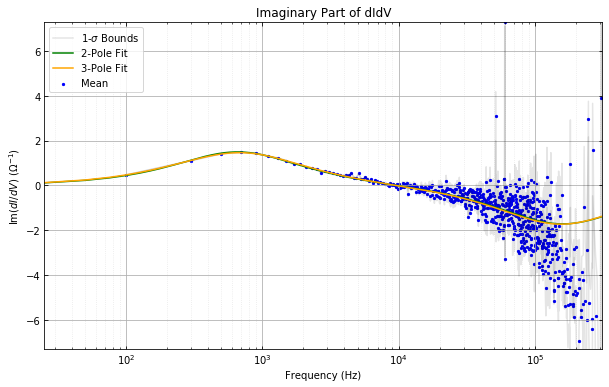

In [13]:
didvfit.plot_re_im_didv(poles=[2, 3], plotpriors=False)

Alternatively, we can look at the absolute value and the phase of the dIdV.

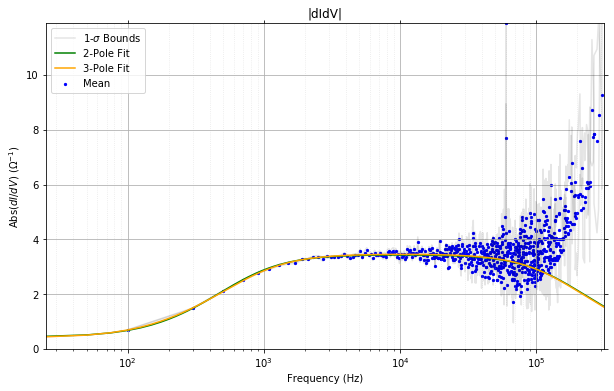

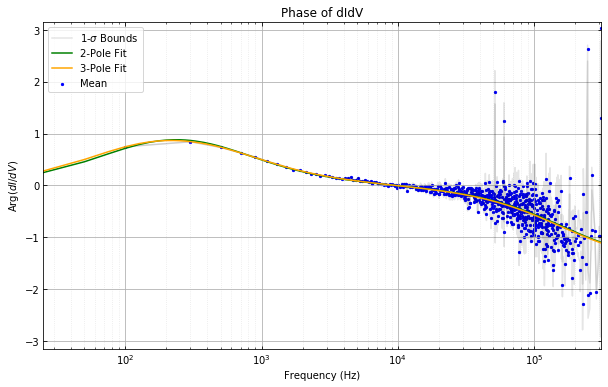

In [14]:
didvfit.plot_abs_phase_didv(poles=[2, 3], plotpriors=False)